In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Here code for fit_ellipse, cart_to_pol and get_ellipse is taken from following blog post:
# https://scipython.com/blog/direct-linear-least-squares-fitting-of-an-ellipse/
# As described in the blog post this implements a numerically stable version
# of the ellipse fitting, described here https://autotrace.sourceforge.net/WSCG98.pdf


def fit_ellipse(x, y):
    """

    Fit the coefficients a,b,c,d,e,f, representing an ellipse described by
    the formula F(x,y) = ax^2 + bxy + cy^2 + dx + ey + f = 0 to the provided
    arrays of data points x=[x1, x2, ..., xn] and y=[y1, y2, ..., yn].

    Based on the algorithm of Halir and Flusser, "Numerically stable direct
    least squares fitting of ellipses'.


    """

    D1 = np.vstack([x**2, x * y, y**2]).T
    D2 = np.vstack([x, y, np.ones(len(x))]).T
    S1 = D1.T @ D1
    S2 = D1.T @ D2
    S3 = D2.T @ D2
    T = -np.linalg.inv(S3) @ S2.T
    M = S1 + S2 @ T
    C = np.array(((0, 0, 2), (0, -1, 0), (2, 0, 0)), dtype=float)
    M = np.linalg.inv(C) @ M
    # pylint: disable=unused-variable
    eigval, eigvec = np.linalg.eig(M)
    con = 4 * eigvec[0] * eigvec[2] - eigvec[1]**2
    ak = eigvec[:, np.nonzero(con > 0)[0]]
    return np.concatenate((ak, T @ ak)).ravel()


def cart_to_pol(coeffs):
    """

    Convert the cartesian conic coefficients, (a, b, c, d, e, f), to the
    ellipse parameters, where F(x, y) = ax^2 + bxy + cy^2 + dx + ey + f = 0.
    The returned parameters are x0, y0, ap, bp, e, phi, where (x0, y0) is the
    ellipse centre; (ap, bp) are the semi-major and semi-minor axes,
    respectively; e is the eccentricity; and phi is the rotation of the semi-
    major axis from the x-axis.

    """

    # We use the formulas from https://mathworld.wolfram.com/Ellipse.html
    # which assumes a cartesian form ax^2 + 2bxy + cy^2 + 2dx + 2fy + g = 0.
    # Therefore, rename and scale b, d and f appropriately.
    a = coeffs[0]
    b = coeffs[1] / 2
    c = coeffs[2]
    d = coeffs[3] / 2
    f = coeffs[4] / 2
    g = coeffs[5]

    den = b**2 - a * c
    if den > 0:
        raise ValueError('coeffs do not represent an ellipse: b^2 - 4ac must'
                         ' be negative!')

    # The location of the ellipse centre.
    x0, y0 = (c * d - b * f) / den, (a * f - b * d) / den

    num = 2 * (a * f**2 + c * d**2 + g * b**2 - 2 * b * d * f - a * c * g)
    fac = np.sqrt((a - c)**2 + 4 * b**2)
    # The semi-major and semi-minor axis lengths (these are not sorted).
    ap = np.sqrt(num / den / (fac - a - c))
    bp = np.sqrt(num / den / (-fac - a - c))

    # Sort the semi-major and semi-minor axis lengths but keep track of
    # the original relative magnitudes of width and height.
    width_gt_height = True
    if ap < bp:
        width_gt_height = False
        ap, bp = bp, ap

    # The eccentricity.
    r = (bp / ap)**2
    if r > 1:
        r = 1 / r
    e = np.sqrt(1 - r)

    # The angle of anticlockwise rotation of the major-axis from x-axis.
    if b == 0:
        phi = 0 if a < c else np.pi / 2
    else:
        phi = np.arctan((2. * b) / (a - c)) / 2
        if a > c:
            phi += np.pi / 2
    if not width_gt_height:
        # Ensure that phi is the angle to rotate to the semi-major axis.
        phi += np.pi / 2
    phi = phi % np.pi

    return x0, y0, ap, bp, e, phi


def get_ellipse_pts(params, npts=100, tmin=0, tmax=2 * np.pi):
    """
    Return npts points on the ellipse described by the params = x0, y0, ap,
    bp, e, phi for values of the parametric variable t between tmin and tmax.

    """

    x0, y0, ap, bp, phi = params
    # A grid of the parametric variable, t.
    t = np.linspace(tmin, tmax, npts)
    x = x0 + ap * np.cos(t) * np.cos(phi) - bp * np.sin(t) * np.sin(phi)
    y = y0 + ap * np.cos(t) * np.sin(phi) + bp * np.sin(t) * np.cos(phi)
    return x, y



Exact parameters:
x0, y0, ap, bp, phi = 4 -3.5 7 3 0.7853981633974483
Fitted parameters:
a, b, c, d, e, f = [ -0.51217303   0.69701784  -0.50184153   6.47368007  -6.28479622
 -16.19974828]
x0, y0, ap, bp, e, phi =  3.903682103243742 -3.550782419888837 6.922614758454805 2.9792452992638636 0.9026553539858875 0.7928088371272058


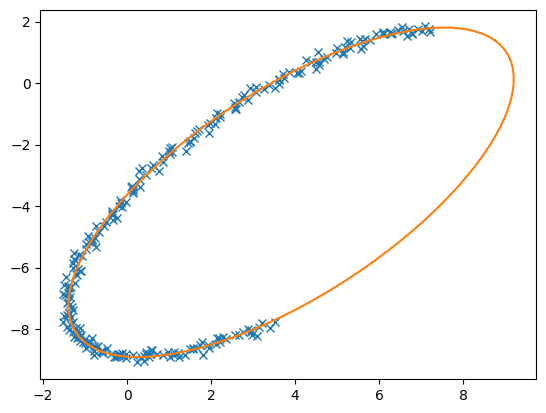

In [6]:
npts = 250
tmin, tmax = np.pi / 6, 4 * np.pi / 3
x0, y0 = 4, -3.5
ap, bp = 7, 3
phi = np.pi / 4
# Get some points on the ellipse (no need to specify the eccentricity).
x, y = get_ellipse_pts((x0, y0, ap, bp, phi), npts, tmin, tmax)
noise = 0.1
x += noise * np.random.normal(size=npts)
y += noise * np.random.normal(size=npts)

coeffs = fit_ellipse(x, y)
print('Exact parameters:')
print('x0, y0, ap, bp, phi =', x0, y0, ap, bp, phi)
print('Fitted parameters:')
print('a, b, c, d, e, f =', coeffs)
x0, y0, ap, bp, e, phi = cart_to_pol(coeffs)
print('x0, y0, ap, bp, e, phi = ', x0, y0, ap, bp, e, phi)

plt.plot(x, y, 'x')  # given points
x, y = get_ellipse_pts((x0, y0, ap, bp, phi))
plt.plot(x, y)
plt.show()

In [9]:
def project_point(point, ellipse_params):
    x0, y0, ap, bp, phi = ellipse_params

    # shift point and ellipse to origin
    x_shift = point[0] - x0
    y_shift = point[1] - y0
    point_shift = np.array([x_shift, y_shift])

    # rotate point and ellipse to align it with x and y axis
    R = np.array([[np.cos(-phi), -np.sin(-phi)], [np.sin(-phi), np.cos(-phi)]])
    point_rotate = R @ point_shift
    x_rotate = point_rotate[0]
    y_rotate = point_rotate[1]

    # calculate angle of point to x axis
    theta = np.arctan2(y_rotate, x_rotate)

    # find with polar coordinates the point with same angle on ellipse,
    # rotated and shifted projection
    k = ap * bp / np.sqrt(
        np.square(bp) * np.square(np.cos(theta)) +
        np.square(ap) * np.square(np.sin(theta)))
    x_p = k * np.cos(theta)
    y_p = k * np.sin(theta)
    projected_point = np.array([x_p, y_p])

    # rotate back
    R_inv = np.array([[np.cos(phi), -np.sin(phi)], [np.sin(phi), np.cos(phi)]])
    rot_p = R_inv @ projected_point

    # shift back
    x_proj = rot_p[0] + x0
    y_proj = rot_p[1] + y0

    return x_proj, y_proj

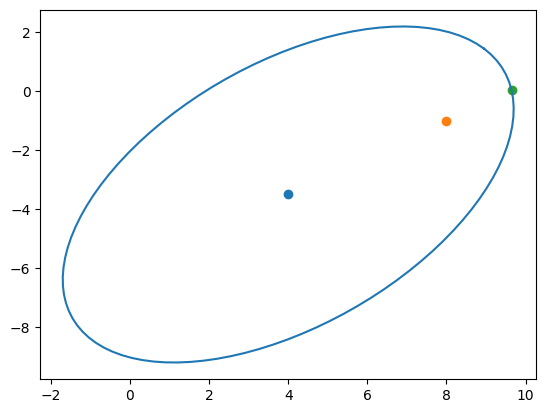

In [10]:
x0, y0 = 4, -3.5
ap, bp = 7, 4
phi = np.pi / 4
# Get some points on the ellipse (no need to specify the eccentricity).
x_e, y_e = get_ellipse_pts((x0, y0, ap, bp, phi))
plt.plot(x_e, y_e)
plt.scatter(x0, y0)

# point to project on to the ellipse
x = 8
y = -1
point = np.array([x, y])
plt.scatter(x, y)

projected_point = project_point(point, (x0, y0, ap, bp, phi))
x_proj, y_proj = projected_point
plt.scatter(x_proj, y_proj)
plt.show()